In [1]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
!mkdir /home/aistudio/external-libraries
# 安装pandas到指定目录
!pip install pandas -t /home/aistudio/external-libraries

# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

mkdir: 无法创建目录"/home/aistudio/external-libraries": 文件已存在
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 650.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 853.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 2.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parl 1.4.1 requires pyzmq==18.1.1, but you have pyzmq 23.2.1 which is incompatible.
paddlefsl 1.0.0 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
paddlefsl 1.0.0 requires tqdm~=4.27.0, but you have tqdm 4.64.1 which is incompatible.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip

In [2]:
#导入需要的包
import os
import numpy as np
from PIL import Image
import cv2
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision.transforms import Compose, Normalize


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [3]:
#解压

import os
import zipfile
path="/home/aistudio/data/data179734"
os.chdir(path)
extract=zipfile.ZipFile("fish_image.zip")
extract.extractall()

# 一、数据处理

In [4]:
import paddle.vision.transforms as T
transforms = T.Compose([
T.Resize((47,47)), # 随机裁剪大小
T.RandomHorizontalFlip(0.5), # 随机水平翻转
T.ToTensor(), # 数据的格式转换和标准化、 HWC => CHW
T.Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5]) # 图像归一化
])

In [5]:
from paddle.io import Dataset
import os
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data_dir, label_path, transform=transforms):
        super(MyDataset, self).__init__()
        self.data_list = []
        with open(label_path,encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
            self.transform = transform

    def __getitem__(self, index):
        image_path, label = self.data_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype('float32')
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([label],dtype = "int64")
        return image, label

    def  __len__ (self):
        return len(self.data_list)

In [6]:
from paddle.vision.transforms import Normalize

train_dataset = MyDataset('./','./train.txt', transforms)
test_dataset = MyDataset('./','./eval.txt', transforms)
print('train_dataset images: ',len(train_dataset), 'test_dataset images: ',len(test_dataset))

train_dataset images:  14550 test_dataset images:  1620


batch_id: 0,训练数据shape: [64, 3, 47, 47],标签数据shape: [64, 1]
train_data 的标签为:Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [1])


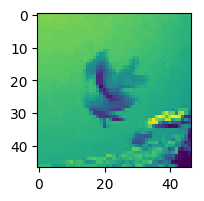

In [8]:
import paddle
import cv2
import matplotlib.pyplot as plt

train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
for batch_id,data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {},训练数据shape: {},标签数据shape: {}".format(batch_id, images.shape, labels.shape))
    plt.figure(figsize=(2,2))
    plt.imshow(images[0][0])
    print('train_data 的标签为:' + str(labels[0]))
    break

# 二、模型设计

In [9]:
import paddle.nn.functional as F
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5,stride=2)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=3,stride=2)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=200, out_features=5)
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x=F.softmax(x)
        return x
    def save(self,adam):
        # 保存Layer参数
        paddle.save(self.state_dict(),"linear_net.pdparams")
        # 保存优化器参数
        paddle.save(adam.state_dict(),"adam.pdopt")
model = MyCNN()
paddle.summary(model,(1, 3, 47, 47))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 3, 47, 47]]     [1, 20, 22, 22]         1,520     
  MaxPool2D-1    [[1, 20, 22, 22]]     [1, 20, 11, 11]           0       
   Conv2D-2      [[1, 20, 11, 11]]      [1, 50, 5, 5]          9,050     
  MaxPool2D-2     [[1, 50, 5, 5]]       [1, 50, 2, 2]            0       
   Linear-1          [[1, 200]]             [1, 5]             1,005     
Total params: 11,575
Trainable params: 11,575
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.17
---------------------------------------------------------------------------



{'total_params': 11575, 'trainable_params': 11575}

# 三、模型训练

In [10]:
#首先定义了横坐标和总坐标数组
x = []#用于存放横坐标
t_loss = []#用于存放train_loss
t_acc = []#用于存放train_acc

In [44]:
import numpy

epochs = 20 # 设置选代次数
optim = paddle.optimizer.Adam(learning_rate=0.002,parameters=model.parameters()) # 设置优化器
loss_fn = paddle.nn.CrossEntropyLoss()
max_acc=0.8
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
        # 训练数据
        x_data = data[0]
        y_data = data[1]
        # 训练数据标签
        # 预测结果
        predicts = model(x_data)
        # 计算损失
        loss = loss_fn(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        loss.backward()
        if (batch_id+1) % 100 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id+1, loss.numpy(), acc.numpy()))
            t_loss.append(loss.numpy())
            t_acc.append(acc.numpy())
            if(acc.numpy()>max_acc):
                model.save(optim)
                max_acc=acc.numpy()
                print("save")
                if(max_acc>0.99):
                    break
        # 更新参数
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch: 0, batch_id: 100, loss is: [1.0618622], acc is: [0.84375]
save
epoch: 0, batch_id: 200, loss is: [1.0498221], acc is: [0.859375]
save
epoch: 1, batch_id: 100, loss is: [1.1303937], acc is: [0.78125]
epoch: 1, batch_id: 200, loss is: [1.1148468], acc is: [0.78125]
epoch: 2, batch_id: 100, loss is: [1.0914197], acc is: [0.8125]
epoch: 2, batch_id: 200, loss is: [1.1177348], acc is: [0.78125]
epoch: 3, batch_id: 100, loss is: [1.0584507], acc is: [0.84375]
epoch: 3, batch_id: 200, loss is: [1.0805966], acc is: [0.8125]
epoch: 4, batch_id: 100, loss is: [1.1241155], acc is: [0.78125]
epoch: 4, batch_id: 200, loss is: [1.0858729], acc is: [0.828125]


Exception in thread Thread-176:
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 620, in _get_data
    data = self._data_queue.get(timeout=self._timeout)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 534, in _thread_loop
    batch = self._get_data()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7

KeyboardInterrupt: 

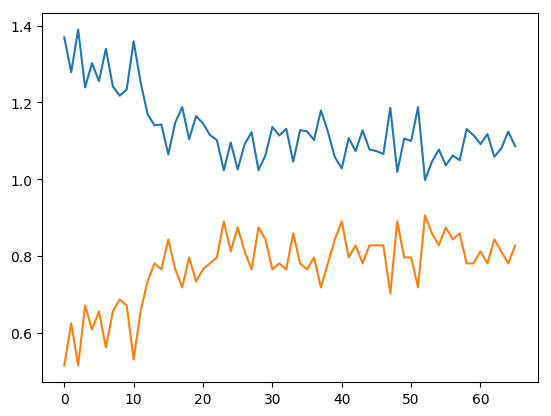

In [45]:
plt.plot(t_loss)
plt.plot(t_acc)
plt.show()

# 四、模型评估与推理

In [46]:
def load(layer,adam):
    # 载入模型参数、优化器参数和最后一个epoch保存的检查点
    layer_state_dict = paddle.load("linear_net.pdparams")
    opt_state_dict = paddle.load("adam.pdopt")
    # 将load后的参数与模型关联起来
    layer.set_state_dict(layer_state_dict)
    adam.set_state_dict(opt_state_dict)

batch_id: 5, loss is: [1.1197499], acc is: [0.78125]
batch_id: 10, loss is: [1.1043293], acc is: [0.796875]
batch_id: 15, loss is: [1.0628188], acc is: [0.84375]
batch_id: 20, loss is: [1.014221], acc is: [0.90625]
batch_id: 25, loss is: [1.1060977], acc is: [0.796875]


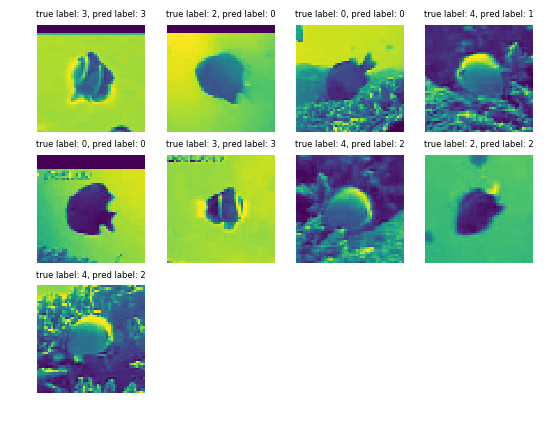

In [68]:
    from paddle.io import RandomSampler,BatchSampler
    
    best=MyCNN()
    optim = paddle.optimizer.Adam(learning_rate=0.001,parameters=best.parameters()) # 设置优化器
    load(best,optim)
    # 加载测试数据集
    test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)# 设置损失函数
    loss_fn = paddle.nn.CrossEntropyLoss()# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
    best.eval()
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        # 测试数据标签
        predicts = best(x_data)
        # 预测结果
        # 计算损失与精度
        loss = loss_fn(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        # 打印信息
        if (batch_id+1) % 5 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id+1, loss.numpy(), acc.numpy()))
    sampler = RandomSampler(test_dataset)
    batch_sampler = BatchSampler(sampler=sampler, batch_size=10)
    i=1
    for img, label in test_loader:
        # 执行推理并打印结果
        pred_label = best(img)[0].argmax()
        #print('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()))# 可视化图片
        plt.subplot(3,4,i)
        i=i+1
        plt.title('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()),fontsize='6')
        plt.imshow(img[0][0])
        plt.axis('off')
        if(i>=10):
            break